In [36]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import time
from matplotlib import pyplot as plt
from PIL import Image
from scipy import misc
import glob

In [37]:
# Loading net skeleton with parameters name and shapes.
with open("util/net_skeleton.ckpt", "rb") as f:
    net_skeleton = cPickle.load(f)

In [38]:
num_layers    = [2, 2, 3, 3, 3, 1, 1, 1]
dilations     = [[1, 1],
                 [1, 1],
                 [1, 1, 1],
                 [1, 1, 1],
                 [2, 2, 2],
                 [12], 
                 [1], 
                 [1]]
n_classes = 21
ks = 3

In [39]:
def create_variable(name, shape):
    """Create a convolution filter variable of the given name and shape,
       and initialise it using Xavier initialisation 
       (http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf).
    """
    initialiser = tf.contrib.layers.xavier_initializer_conv2d(dtype=tf.float32)
    variable = tf.Variable(initialiser(shape=shape), name=name)
    tf.summary.histogram(name, variable)
    return variable

def create_bias_variable(name, shape):
    """Create a bias variable of the given name and shape,
       and initialise it to zero.
    """
    initialiser = tf.constant_initializer(value=0.0, dtype=tf.float32)
    variable = tf.Variable(initialiser(shape=shape), name=name)
    tf.summary.histogram(name, variable)
    return variable

In [40]:
def neural_net_image_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        # TODO: Implement Function
        return tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")
def neural_net_label_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        # TODO: Implement Function
        return tf.placeholder(tf.uint8,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="y")

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32,name="keep_prob")

In [41]:
class DeepLabLFOVModel(object):
    def __init__(self, weights_path=None):
        self.variables = self._create_variables(weights_path)
    
    def _create_variables(self, weights_path):
        var = list()
        index = 0
        
        if weights_path is not None:
            with open(weights_path, "rb") as f:
                weights = cPickle.load(f) # Load pre-trained weights.
                for name, shape in net_skeleton:
                    var.append(tf.Variable(weights[name],
                                           name=name))
                del weights
        else:
            # Initialise all weights randomly with the Xavier scheme,
            # and 
            # all biases to 0's.
            for name, shape in net_skeleton:
                if "/w" in name: # Weight filter.
                    w = create_variable(name, list(shape))
                    var.append(w)
                else:
                    b = create_bias_variable(name, list(shape))
                    var.append(b)
        return var
    
    def _create_network(self, input_batch, keep_prob):
        
        current = input_batch
        v_idx = 0
        for b_idx in range(len(dilations) - 1):
            for l_idx, dilation in enumerate(dilations[b_idx]):
                w = self.variables[v_idx * 2]
                b = self.variables[v_idx * 2 + 1]
                if dilation == 1:
                    conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
                else:
                    conv = tf.nn.atrous_conv2d(current, w, dilation, padding='SAME')
                current = tf.nn.relu(tf.nn.bias_add(conv, b))
                v_idx += 1
                
            if b_idx < 3:
                current = tf.nn.max_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 2, 2, 1],
                                         padding='SAME')
            elif b_idx == 3:
                current = tf.nn.max_pool(current, 
                             ksize=[1, ks, ks, 1],
                             strides=[1, 1, 1, 1],
                             padding='SAME')
            elif b_idx == 4:
                current = tf.nn.max_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 1, 1, 1],
                                         padding='SAME')
                current = tf.nn.avg_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 1, 1, 1],
                                         padding='SAME')
            elif b_idx <= 6:
                current = tf.nn.dropout(current, keep_prob=keep_prob)
        
        # Classification layer; no ReLU.
        w = self.variables[v_idx * 2]
        b = self.variables[v_idx * 2 + 1]
        conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
        current = tf.nn.bias_add(conv, b)

        return current
    
    
    def preds(self, input_batch):
        """Create the network and run inference on the input batch.
        
        Args:
          input_batch: batch of pre-processed images.
          
        Returns:
          Argmax over the predictions of the network of the same shape as the input.
        """
        
        raw_output = self._create_network(tf.cast(input_batch, tf.float32),  keep_prob=tf.constant(1.0))
        #print(raw_output.shape)
        raw_output = tf.image.resize_bilinear(raw_output, tf.shape(input_batch)[1:3,])
        #print(raw_output.shape)
        raw_output = tf.argmax(raw_output, dimension=3)
        #print(raw_output.shape)
        raw_output = tf.expand_dims(raw_output, dim=3) # Create 4D-tensor.
        #print(raw_output.shape)
        return tf.cast(raw_output, tf.uint8)
    
    def loss(self, img_batch, label_batch,keep_prob_input):
        """Create the network, run inference on the input batch and compute loss.
        
        Args:
          input_batch: batch of pre-processed images.
          
        Returns:
          Pixel-wise softmax loss.
        """
        raw_output = self._create_network(tf.cast(img_batch, tf.float32), keep_prob_input)
        #print(raw_output.shape)
        
        
        lbels= tf.image.resize_nearest_neighbor(label_batch,tf.stack(raw_output.get_shape()[1:3]))
        prediction = tf.reshape(raw_output, [-1, n_classes])
        lbels = tf.squeeze(lbels, squeeze_dims=[3]) # Reducing the channel dimension.
        lbels = tf.one_hot(lbels, depth=21)
        gt = tf.reshape(lbels, [-1, n_classes])
        #print(label_batch.shape)
        # Pixel-wise softmax loss.
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=gt)
        reduced_loss = tf.reduce_mean(loss)
        return reduced_loss

In [42]:
def prepare_label(label_batch):
        colormap = {(0,0,0):0, (128,0,0):1, (0,128,0):2, (128,128,0):3, (0,0,128):4, (128,0,128):5, (0,128,128):6, (128,128,128):7, (64,0,0):8, (192,0,0):9, (64,128,0):10, (192,128,0):11, (64,0,128):12, (192,0,128):13, 
            (64,128,128):14, (192,128,128):15, (0,64,0):16, (128,64,0):17, (0,192,0):18, (128,192,0):19, (0,64,128):20}                                            
        gndTruth = np.zeros((label_batch.shape[0],label_batch[0].shape[0],label_batch[0].shape[1],21), dtype=np.int)
        for i in range(label_batch.shape[0]):
            for j in range(label_batch[0].shape[0]):
                for k in range(label_batch[0].shape[1]):   
                    if(colormap.get(tuple(label_batch[i][j,k]))):
                        gndTruth[i,j,k,colormap.get(tuple(label_batch[i][j,k]))] = 1
                    else:
                        gndTruth[i,j,k,0] = 1
        return gndTruth

In [43]:
# Colour map.
label_colours = [(0,0,0)
                # 0=background
                ,(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128)
                # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                ,(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0)
                # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                ,(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128)
                # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                ,(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
                # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    
def decode_labels(mask):
    """Decode batch of segmentation masks.
    
    Args:
      label_batch: result of inference after taking argmax.
    
    Returns:
      An batch of RGB images of the same size
    """
    img = Image.new('RGB', (len(mask[0]), len(mask)))
    pixels = img.load()
    for j_, j in enumerate(mask):
        for k_, k in enumerate(j):
            if k < 21:
                pixels[k_,j_] = label_colours[k]
    return np.array(img)
def encode_labels(label_batch):
        colormap = {(0,0,0):0, (128,0,0):1, (0,128,0):2, (128,128,0):3, (0,0,128):4, (128,0,128):5, (0,128,128):6, (128,128,128):7, (64,0,0):8, (192,0,0):9, (64,128,0):10, (192,128,0):11, (64,0,128):12, (192,0,128):13, 
            (64,128,128):14, (192,128,128):15, (0,64,0):16, (128,64,0):17, (0,192,0):18, (128,192,0):19, (0,64,128):20}                                            
        gndTruth = np.zeros((label_batch.shape[0],label_batch[0].shape[0],label_batch[0].shape[1],1), dtype=np.int)
        for i in range(gndTruth.shape[0]):
            for j in range(gndTruth.shape[1]):
                for k in range(gndTruth.shape[2]):   
                    if(colormap.get(tuple(label_batch[i][j,k]))):
                        gndTruth[i,j,k]=colormap.get(tuple(label_batch[i][j,k]))
                    else:
                        gndTruth[i,j,k] = 0
        return gndTruth

In [59]:
def load_preprocess_training_batch(batch_id):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    path = 'VOCdevkit/VOC2012/'
    x='2007_000032'
    features = np.array([misc.imread(path+"JPEGImages/"+x+".jpg")])
    labels = np.array([misc.imread(path+"SegmentationClass/"+x+".png")])
    # Return the training data in batches of size <batch_size> or less
    return features, labels
# def load_preprocess_training_batch(batch_id):
#     """
#     Load the Preprocessed Training data and return them in batches of <batch_size> or less
#     """
#     filename = 'data/pre_processed_batch_' + str(batch_id) + '.p'
#     loaded_features, loaded_labels = cPickle.load(open(filename, mode='rb'))
#     # Return the training data in batches of size <batch_size> or less
#     return loaded_features, loaded_labels

In [58]:
save_model_path = "experiment"
image_save_path = "images/"
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((500, 500, 3))
y = neural_net_label_input((500, 500, 1))
# x = tf.image.resize_image_with_crop_or_pad(x,320,320)
# y = tf.image.resize_image_with_crop_or_pad(y,320,320)
keep_prob = neural_net_keep_prob_input()
keep_prob_pred=tf.placeholder(tf.float32,name="keep_prob_pred")
net = DeepLabLFOVModel()
cost = net.loss(x, y,keep_prob)
cost_summary=tf.summary.scalar("loss",cost)
optim = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
saver = tf.train.Saver(max_to_keep=40);  
pred = net.preds(x)

Instructions for updating:
Use the `axis` argument instead


In [60]:
x

<tf.Tensor 'x:0' shape=(?, 500, 500, 3) dtype=float32>

In [46]:
sess = tf.Session()
merged = tf.summary.merge_all()
file_writer = tf.summary.FileWriter('logs/', sess.graph)
sess.run(tf.global_variables_initializer())

In [47]:
batch_i=0
epoch=0
keep_probability = 0.75
IMG_MEAN = np.array((116.66876762,104.00698793,122.67891434), dtype=np.float32)
start_time = time.time()
batch_features, batch_labels = load_preprocess_training_batch(batch_i)

In [48]:
img_tensor = tf.image.resize_image_with_crop_or_pad(batch_features, 500, 500)
#batch_input_resized = batch_input_resized - IMG_MEAN
batch_labels_tensor = tf.image.resize_image_with_crop_or_pad(batch_labels, 500, 500)

In [49]:
img,labels = sess.run([img_tensor,batch_labels_tensor])

In [50]:
img[:,:,:] = img[:,:,:] - IMG_MEAN

In [51]:
batch_labels_array_new = encode_labels(labels)

In [17]:
img.shape

(1, 500, 500, 3)

In [19]:
batch_features.shape

(1, 281, 500, 3)

In [55]:
for epoch in range(0,1):
    loss_value,op,_=sess.run([cost,pred,optim],feed_dict={x:img,y:batch_labels_array_new,keep_prob:keep_probability,keep_prob_pred:1.0})
    #file_writer.add_summary(summary_variable, epoch)

In [489]:
raw_output = net._create_network(x, keep_prob)

In [490]:
res1=sess.run(raw_output,feed_dict={x:img,keep_prob:keep_probability})

In [491]:
raw_output.shape

TensorShape([Dimension(None), Dimension(63), Dimension(63), Dimension(21)])

In [492]:
batch_features.shape[0]

1

In [22]:
loss_value

2253219.2

In [494]:
label_op= tf.image.resize_nearest_neighbor(y,tf.stack(raw_output.get_shape()[1:3]))

In [495]:
lbl1 = sess.run(label_op,feed_dict={y:batch_labels_array_new})

In [496]:
lbl1.shape

(1, 63, 63, 1)

In [505]:
prediction = tf.reshape(raw_output, [-1, n_classes])


In [506]:
labels = tf.squeeze(label_op, squeeze_dims=[3]) # Reducing the channel dimension.


In [508]:
lbl2 = sess.run(labels,feed_dict={y:batch_labels_array_new})

In [526]:
count=0
for i in range(63):
    for j in range(63):
        if(lbl2[0,i,j]!=0):
            print(lbl2[0,i,j])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
15
15
15
15
15
15
15
15
15
15
15
15
15


In [512]:
count

87

In [514]:
labels = tf.one_hot(labels, depth=21)


In [516]:
lbl3 = sess.run(labels,feed_dict={y:batch_labels_array_new})

In [517]:
lbl3.shape

(1, 63, 63, 21)

In [521]:
lbl3

array([[[[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        ..., 
        [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1., 

In [527]:
count=0
for i in range(63):
    for j in range(63):
        for k in range(1,21):
            if(lbl3[0,i,j,k]!=0):
                print(i,j,k, lbl3[0,i,j,k])
                count+=1

25 24 1 1.0
26 24 1 1.0
27 18 1 1.0
27 19 1 1.0
27 20 1 1.0
27 21 1 1.0
27 22 1 1.0
27 23 1 1.0
27 24 1 1.0
28 18 1 1.0
28 21 1 1.0
28 27 1 1.0
28 28 1 1.0
28 29 1 1.0
28 30 1 1.0
28 31 1 1.0
28 33 1 1.0
28 34 1 1.0
29 26 1 1.0
29 27 1 1.0
29 28 1 1.0
29 29 1 1.0
29 30 1 1.0
29 31 1 1.0
29 32 1 1.0
29 33 1 1.0
29 34 1 1.0
30 14 1 1.0
30 15 1 1.0
30 16 1 1.0
30 17 1 1.0
30 18 1 1.0
30 19 1 1.0
30 20 1 1.0
30 21 1 1.0
30 26 1 1.0
30 27 1 1.0
30 28 1 1.0
30 29 1 1.0
30 30 1 1.0
30 31 1 1.0
30 43 1 1.0
30 44 1 1.0
30 45 1 1.0
30 46 1 1.0
30 47 1 1.0
31 26 1 1.0
31 27 1 1.0
31 28 1 1.0
31 29 1 1.0
31 30 1 1.0
31 32 1 1.0
31 33 1 1.0
31 34 1 1.0
31 35 1 1.0
32 26 1 1.0
32 27 1 1.0
32 28 1 1.0
32 29 1 1.0
32 30 1 1.0
33 26 1 1.0
33 27 1 1.0
33 28 1 1.0
33 29 1 1.0
33 30 1 1.0
33 33 1 1.0
34 26 1 1.0
34 27 1 1.0
34 28 1 1.0
34 29 1 1.0
35 27 1 1.0
35 28 1 1.0
36 27 1 1.0
36 28 1 1.0
37 26 15 1.0
38 4 15 1.0
38 25 15 1.0
38 26 15 1.0
39 4 15 1.0
39 25 15 1.0
39 26 15 1.0
40 4 15 1.0
40 5 15 1.0

In [528]:
count

87

In [ ]:

gt = tf.reshape(labels, [-1, n_classes])

In [499]:
lbl2 = sess.run(gt,feed_dict={y:batch_labels_array_new})

In [533]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=gt)

In [534]:
sess.run(loss,feed_dict={x:img,keep_prob:keep_probability,y:batch_labels_array_new})

array([ 3.32830977,  2.91328859,  2.82289863, ...,  3.4458065 ,
        3.20261836,  3.0960083 ], dtype=float32)

In [535]:
reduced_loss = tf.reduce_mean(loss)

In [536]:
sess.run(reduced_loss,feed_dict={x:img,keep_prob:keep_probability,y:batch_labels_array_new})

3.2123799

In [537]:
opt = sess.run(pred,feed_dict={x:img,keep_prob:keep_probability,y:batch_labels_array_new})

In [541]:
opt

array([[[[19],
         [19],
         [19],
         ..., 
         [19],
         [19],
         [19]],

        [[19],
         [19],
         [19],
         ..., 
         [19],
         [19],
         [19]],

        [[19],
         [19],
         [19],
         ..., 
         [19],
         [19],
         [19]],

        ..., 
        [[18],
         [18],
         [18],
         ..., 
         [13],
         [13],
         [13]],

        [[18],
         [18],
         [18],
         ..., 
         [13],
         [13],
         [13]],

        [[18],
         [18],
         [18],
         ..., 
         [13],
         [13],
         [13]]]], dtype=uint8)

In [56]:
plt.imshow(decode_labels(op[0,:,:,0]))

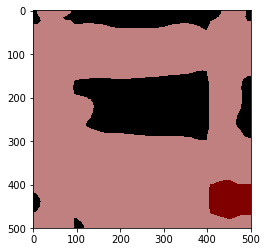

In [57]:
plt.show()

In [433]:
lbls = decode_labels(op[0,:,:,0])

In [434]:
plt.imshow(lbls)

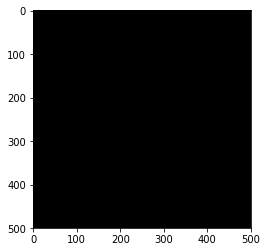

In [435]:
plt.show()